$$\textrm{Joaquin Peñuela Parra}$$
$$\textrm{University of Los Andes}$$
$$\textrm{High Energy Physics Group: Phenomenology of Particles}$$

This code was written to be running in Docker. If you do not have a Docker inside hep-server2 please refer to: https://github.com/Phenomenology-group-uniandes/Tutoriales_Generales

In [1]:
import os, sys

def add_parent_lib_path(name="Leptoquarks_Searches_2023"):
    sys.path.append(sys.path[0].split(name)[0])
    
add_parent_lib_path()

In [2]:
from Uniandes_Framework.ml_tools import tools
from Uniandes_Framework.delphes_reader import root_analysis

import pandas as pd

from ROOT import TCanvas #Permite poner los histogramas
from ROOT import THStack #Permite graficar varios histogramas al mismo tiempo
from ROOT import TLegend #Permite poner legends cuando se sobrelapan histogramas
from ROOT import TLatex #Permite poner avisos en Latex en las graficas

Welcome to JupyROOT 6.22/06


In [3]:
Path_Leptoquarks_searches = os.path.dirname(os.path.dirname(os.path.realpath('XBG_Outputs_Plots_Article.ipynb')))

channels = ["hadronic_dLQ", "hadronic_sLQ", "hadronic_non-resonant", "semileptonic_dLQ", "semileptonic_sLQ", "semileptonic_non-resonant"]
signals = ['LQ_LQ', 'Tau_LQ', 'Tau_Tau'] + ['LQ_LQ_wo_RHC', 'Tau_LQ_wo_RHC', 'Tau_Tau_wo_RHC']
Masses = [
    # "1000" ,
    # '1250', 
    '1500', 
    # '1750', 
    # '2000', 
    # '2250', 
    # '2500'
]
bkgs = ['ttbar', 'z_jets', 'w_jets', 'stop','ww', 'wz', 'zz']

suffix_by_betard = {'wRHC': '', 'woRHC': '_wo_RHC'}
header_by_betard = {'wRHC': '#beta_{R} = -1', 'woRHC': '#beta_{R} = 0'}

In [4]:
all_histograms = {}

In [5]:
for betard in suffix_by_betard:
    all_histograms[betard] = {}

    for channel in channels:    
        all_histograms[betard][channel] = {}
        for Mass in Masses:
            path_root_file = os.path.join(f'{Path_Leptoquarks_searches}', '05_ML_Final_Distribution','Histograms', channel,f'M{Mass}', f'All_Histograms.root')   
            all_histograms[betard][channel][f'M{Mass}'] = root_analysis.read_root_file(path_root_file, expected_keys = ['Lq Lq', '#tau Lq', '#tau #tau', 'Combined', 't#bar{t}', 'stop', 'Diboson', 'V+jets'])

In [6]:
all_histograms[betard][channel][f'M{Mass}'].keys()

dict_keys(['Lq Lq', '#tau Lq', '#tau #tau', 'Combined', 't#bar{t}', 'stop', 'Diboson', 'V+jets'])

In [7]:
channel

'semileptonic_non-resonant'

In [8]:
def Overlap_Histos(Histograms, 
                   betard,
                   channel,
                   Mass, 
                   Title_Plot, 
                   Signal_to_ignore = '', 
                   alpha_bkg = 0.05, 
                   alpha_signal = 0.05, 
                   Log_Y = False, 
                   Log_X = True, 
                   Grid = False):
    
    #if Stack is False -> Histograms will be normalized by A.U
    #if Stack is True -> Histograms will be normalized by number of physical events
    
    #canvas = TCanvas(Title_Plot, " ", 0, 0, 1280, 720)
    canvas = TCanvas(Title_Plot, " ", 0, 0, 800, 600)
    
    #legend = TLegend(0.9,.4,1,.89) #Legend outside the graph
    legend = TLegend(0.48,.75,0.87,.89)
    legend.SetTextFont(132)                   
    legend.SetNColumns(4) 
    legend.SetHeader('M_{U}' + f'= {int(Mass)/1000} TeV' + ', g_{U} = 1.8' + ', ' + header_by_betard[betard],"C")
    legend.SetLineWidth(1)
    #legend.SetFillStyle(0) #Transparent legend window
    
    x_axis = 'XGB-Output'
    
    Histos = THStack('hist', Title_Plot)
    
    Plotting_Order = ['t#bar{t}', 'stop', 'Diboson', 'V+jets', 'Lq Lq', '#tau Lq', '#tau #tau', 'Combined']
    
    Dict_Hist = Histograms[betard][channel][f'M{Mass}']
    holes = root_analysis.review_holes_in_histograms(Dict_Hist)
    
    colors = [94,6,3,209,1,2,226,4] #https://root-forum.cern.ch/t/what-is-your-best-way-to-increment-colors/13809
    for i, key in enumerate(Plotting_Order):
        
        if key in holes: histo = root_analysis.fill_holes_in_histogram(Dict_Hist[key])
        else: histo = Dict_Hist[key]
        
        color = colors[i]
        histo.SetLineColor(color)
        
        if key in ['t#bar{t}', 'stop', 'Diboson', 'V+jets']: alpha = alpha_bkg
        else: alpha = alpha_signal
        histo.SetFillColorAlpha(color, alpha)
        histo.SetDirectory(0)  
        Histos.Add(histo)
        label = key.replace('Lq Lq', 'dLQ').replace('#tau Lq', 'sLQ').replace('#tau #tau', 'non-res').replace('Diboson', 'VV')
        legend.AddEntry(histo,label)
            
    if Log_Y: canvas.SetLogy()
    if Log_X: canvas.SetLogx()
    if Grid: canvas.SetGrid()
        
    Histos.Draw("histnostack")
    Histos.SetTitle(f'; {x_axis}; A.U')  
    
    latex = TLatex()
    latex.SetNDC()
    latex.SetTextSize(0.04)
    latex.SetTextFont(22) #https://root.cern.ch/doc/master/classTAttText.html
    latex.DrawLatex(0.76,0.92,'#sqrt{s} = 13 TeV')
    latex.DrawLatex(0.1,0.92,Title_Plot)

    Histos.GetXaxis().SetTitleFont(132)
    Histos.GetXaxis().SetLabelFont(132)
    Histos.GetYaxis().SetTitleFont(132)
    Histos.GetYaxis().SetLabelFont(132)           

    canvas.Draw()
    legend.Draw('same')
    
    #Histos.GetXaxis().SetLimits(0.0, float(Mass)*3)          
                
    return Histos, canvas, legend

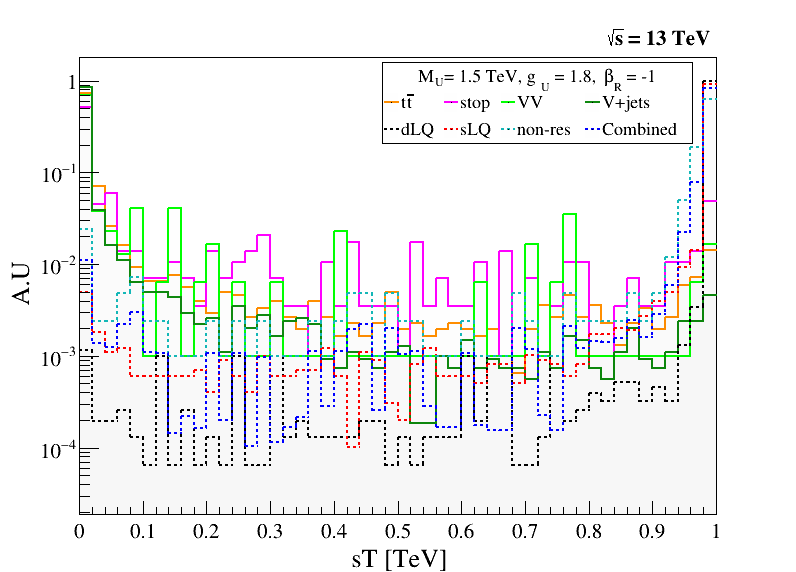

In [9]:
Histos, canvas, legend = Overlap_Histos(Histograms= all_histograms, 
                                       betard = 'wRHC',
                                       channel = "hadronic_dLQ",
                                       Mass = '1500', 
                                       Title_Plot = '', 
                                       Signal_to_ignore = '', 
                                       alpha_bkg = 0.0, 
                                       alpha_signal = 0.00, 
                                       Log_Y = True, 
                                       Log_X = False, 
                                       Grid = False)

Histos.SetTitle('; sT [TeV]; A.U') 
Histos.GetXaxis().CenterTitle(True)
Histos.GetYaxis().CenterTitle(True)

Histos.GetXaxis().SetTitleSize(0.05)
Histos.GetYaxis().SetTitleSize(0.05)
Histos.GetXaxis().SetLabelSize(0.04)
Histos.GetYaxis().SetLabelSize(0.04)

Histos.GetXaxis().SetLabelOffset(0.01)
Histos.GetYaxis().SetLabelOffset(0.0001)
Histos.GetXaxis().SetTitleOffset(1.0)
Histos.GetYaxis().SetTitleOffset(0.95)

Histos.GetXaxis().SetMaxDigits(2)
Histos.GetYaxis().SetMaxDigits(1)    

Info in <TCanvas::Print>: pdf file Article_Histograms/ML_hadronic_dLQ_wRHC.pdf has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: bb#tau_{h}#tau_{h}
Info in <TCanvas::Print>: pdf file Article_Histograms/ML_hadronic_dLQ_woRHC.pdf has been created
Info in <TCanvas::Print>: pdf file Article_Histograms/ML_hadronic_sLQ_wRHC.pdf has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: b#tau_{h}#tau_{h}
Info in <TCanvas::Print>: pdf file Article_Histograms/ML_hadronic_sLQ_woRHC.pdf has been created
Info in <TCanvas::Print>: pdf file Article_Histograms/ML_hadronic_non-resonant_wRHC.pdf has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: #tau_{h}#tau_{h}
Info in <TCanvas::Print>: pdf file Article_Histograms/ML_hadronic_non-resonant_woRHC.pdf has been created
Info in <TCanvas::Print>: pdf file Article_Histograms/ML_semileptonic_dLQ_wRHC.pdf has been created
Warning in <TCanvas::Constructor>: Deleting canv

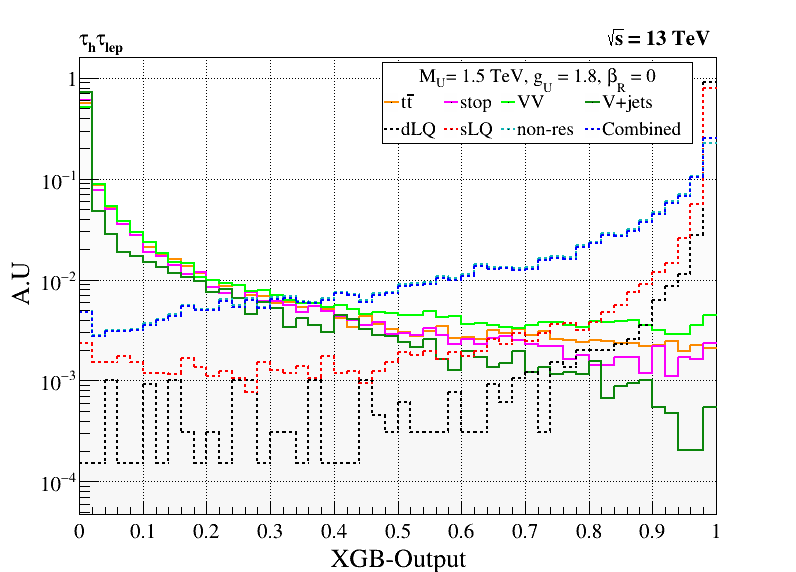

In [10]:
try: os.mkdir('Article_Histograms')
except: pass

M = '1500'

for process in channels:

    if (process == 'hadronic_non-resonant'): titulo = '#tau_{h}#tau_{h}'
    if (process == 'hadronic_sLQ'): titulo = 'b#tau_{h}#tau_{h}'
    if (process == 'hadronic_dLQ'): titulo = 'bb#tau_{h}#tau_{h}'
    if (process == 'semileptonic_non-resonant'): titulo = '#tau_{h}#tau_{lep}'
    if (process == 'semileptonic_sLQ'): titulo = 'b#tau_{h}#tau_{lep}'
    if (process == 'semileptonic_dLQ'): titulo = 'bb#tau_{h}#tau_{lep}' 

    Histos, canvas, legend = Overlap_Histos(Histograms = all_histograms, 
                                   betard = 'wRHC',
                                   channel = process,
                                   Mass = M, 
                                   Title_Plot = titulo, 
                                   Signal_to_ignore = '', 
                                   alpha_bkg = 0.0, 
                                   alpha_signal = 0.00, 
                                   Log_Y = True, 
                                   Log_X = False, 
                                   Grid = False)

    Histos.GetXaxis().CenterTitle(True)
    Histos.GetYaxis().CenterTitle(True)
    
    Histos.GetXaxis().SetTitleSize(0.05)
    Histos.GetYaxis().SetTitleSize(0.05)
    Histos.GetXaxis().SetLabelSize(0.04)
    Histos.GetYaxis().SetLabelSize(0.04)
    
    Histos.GetXaxis().SetLabelOffset(0.01)
    Histos.GetYaxis().SetLabelOffset(0.0001)
    Histos.GetXaxis().SetTitleOffset(1.0)
    Histos.GetYaxis().SetTitleOffset(0.95)
    
    Histos.GetXaxis().SetMaxDigits(2)
    Histos.GetYaxis().SetMaxDigits(1)    
    canvas.SetGrid()
    canvas.SaveAs(os.path.join('Article_Histograms', f'ML_{process}_wRHC.pdf')) 
    
    Histos, canvas, legend = Overlap_Histos(Histograms = all_histograms, 
                                   betard = 'woRHC',
                                   channel = process,
                                   Mass = M, 
                                   Title_Plot = titulo, 
                                   Signal_to_ignore = '', 
                                   alpha_bkg = 0.0, 
                                   alpha_signal = 0.00, 
                                   Log_Y = True, 
                                   Log_X = False, 
                                   Grid = False)

    Histos.GetXaxis().CenterTitle(True)
    Histos.GetYaxis().CenterTitle(True)
    
    Histos.GetXaxis().SetTitleSize(0.05)
    Histos.GetYaxis().SetTitleSize(0.05)
    Histos.GetXaxis().SetLabelSize(0.04)
    Histos.GetYaxis().SetLabelSize(0.04)
    
    Histos.GetXaxis().SetLabelOffset(0.01)
    Histos.GetYaxis().SetLabelOffset(0.0001)
    Histos.GetXaxis().SetTitleOffset(1.0)
    Histos.GetYaxis().SetTitleOffset(0.95)
    
    Histos.GetXaxis().SetMaxDigits(2)
    Histos.GetYaxis().SetMaxDigits(1)    
    canvas.SetGrid()
    canvas.SaveAs(os.path.join('Article_Histograms', f'ML_{process}_woRHC.pdf')) 

In [11]:
#Valores de Combined en 0.7 de la grafica del paper:

In [12]:
import numpy as np

In [13]:
data = np.loadtxt('Histograms/semileptonic_sLQ/M1500/high_per_bin_Combined.txt')

In [14]:
data

array([0.00291788, 0.00396881, 0.00275308, 0.00492468, 0.003121  ,
       0.00235465, 0.00453108, 0.00252801, 0.00332298, 0.0030531 ,
       0.00491315, 0.00437336, 0.00507943, 0.0060634 , 0.00640304,
       0.00654495, 0.00571854, 0.00639838, 0.00572096, 0.00823851,
       0.00857557, 0.00907294, 0.0072395 , 0.00826495, 0.00712865,
       0.008623  , 0.00799915, 0.01151965, 0.00712548, 0.00926248,
       0.0081645 , 0.00883989, 0.01239705, 0.00873984, 0.01109464,
       0.01113799, 0.01284495, 0.01394296, 0.01517133, 0.01748804,
       0.01601582, 0.01856614, 0.02187986, 0.03025638, 0.03030702,
       0.03870396, 0.04095736, 0.05893657, 0.08838853, 0.35842681])

In [15]:
data[-15:]

array([0.01113799, 0.01284495, 0.01394296, 0.01517133, 0.01748804,
       0.01601582, 0.01856614, 0.02187986, 0.03025638, 0.03030702,
       0.03870396, 0.04095736, 0.05893657, 0.08838853, 0.35842681])

In [16]:
np.sum(data[-15:])

0.7730237245559692

In [17]:
np.sum(data[:-15])

0.22697627707384527

Final Plots

Info in <TCanvas::Print>: pdf file Article_Histograms/ML_semileptonic_sLQ_wRHC.pdf has been created


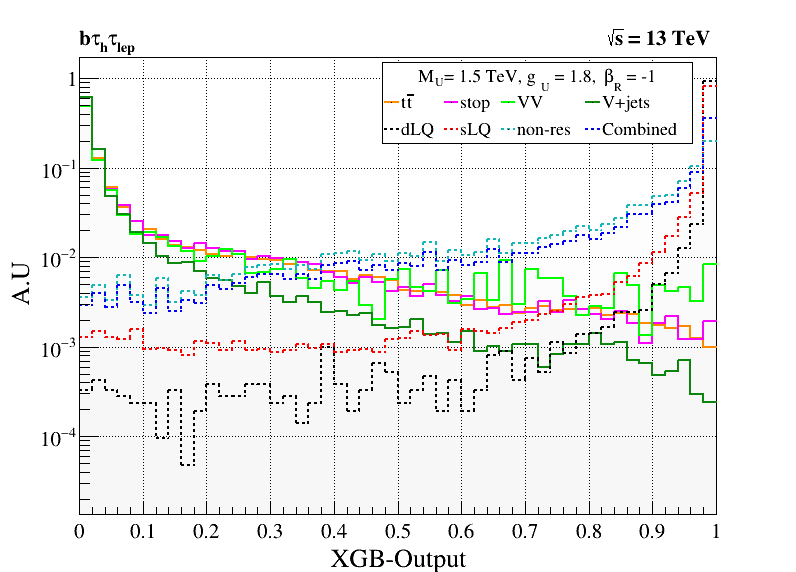

In [18]:
try: os.mkdir('Article_Histograms')
except: pass

M = '1500'

process = 'semileptonic_sLQ'
titulo = 'b#tau_{h}#tau_{lep}'

Histos, canvas, legend = Overlap_Histos(Histograms = all_histograms, 
                               betard = 'wRHC',
                               channel = process,
                               Mass = M, 
                               Title_Plot = titulo, 
                               Signal_to_ignore = '', 
                               alpha_bkg = 0.0, 
                               alpha_signal = 0.00, 
                               Log_Y = True, 
                               Log_X = False, 
                               Grid = False)

Histos.GetXaxis().CenterTitle(True)
Histos.GetYaxis().CenterTitle(True)

Histos.GetXaxis().SetTitleSize(0.05)
Histos.GetYaxis().SetTitleSize(0.05)
Histos.GetXaxis().SetLabelSize(0.04)
Histos.GetYaxis().SetLabelSize(0.04)

Histos.GetXaxis().SetLabelOffset(0.01)
Histos.GetYaxis().SetLabelOffset(0.0001)
Histos.GetXaxis().SetTitleOffset(1.0)
Histos.GetYaxis().SetTitleOffset(0.95)

Histos.GetXaxis().SetMaxDigits(2)
Histos.GetYaxis().SetMaxDigits(1)    
canvas.SetGrid()
canvas.SaveAs(os.path.join('Article_Histograms', f'ML_{process}_wRHC.pdf')) 

In [19]:
def Overlap_Histos(Histograms, 
                   betard,
                   channel,
                   Mass, 
                   Title_Plot, 
                   Signal_to_ignore = '', 
                   alpha_bkg = 0.05, 
                   alpha_signal = 0.05, 
                   Log_Y = False, 
                   Log_X = True, 
                   Grid = False):
    
    #if Stack is False -> Histograms will be normalized by A.U
    #if Stack is True -> Histograms will be normalized by number of physical events
    
    #canvas = TCanvas(Title_Plot, " ", 0, 0, 1280, 720)
    canvas = TCanvas(Title_Plot, " ", 0, 0, 800, 600)
    
    #legend = TLegend(0.9,.4,1,.89) #Legend outside the graph
    legend = TLegend(0.48,.75,0.87,.89)
    legend.SetTextFont(132)                   
    legend.SetNColumns(4) 
    legend.SetHeader('M_{U}' + f'= {int(Mass)/1000} TeV' + ', g_{U} = 1.8' + ', ' + header_by_betard[betard],"C")
    legend.SetLineWidth(1)
    #legend.SetFillStyle(0) #Transparent legend window
    
    x_axis = 'XGB-Output'
    
    Histos = THStack('hist', Title_Plot)
    
    Plotting_Order = ['t#bar{t}', 'stop', 'Diboson', 'V+jets', 'Lq Lq', '#tau Lq', '#tau #tau', 'Combined']
    
    Dict_Hist = Histograms[betard][channel][f'M{Mass}']
    holes = root_analysis.review_holes_in_histograms(Dict_Hist)
    
    colors = [94,6,3,209,1,2,226,4] #https://root-forum.cern.ch/t/what-is-your-best-way-to-increment-colors/13809
    for i, key in enumerate(Plotting_Order):
        
        if key in holes: histo = root_analysis.fill_holes_in_histogram(Dict_Hist[key])
        else: histo = Dict_Hist[key]
        
        color = colors[i]
        histo.SetLineColor(color)
        
        if key in ['t#bar{t}', 'stop', 'Diboson', 'V+jets']: alpha = alpha_bkg
        else: alpha = alpha_signal

        if key == '#tau Lq':
            weight = 58.7/378.5
            histo.Scale(weight/histo.Integral())
        if key == 'Lq Lq':
            weight = 34.3/378.5
            histo.Scale(weight/histo.Integral())
        if key == '#tau #tau':
            weight = 285.5/378.5
            histo.Scale(weight/histo.Integral())   
            
        histo.SetFillColorAlpha(color, alpha)
        histo.SetDirectory(0)  
        Histos.Add(histo)
        label = key.replace('Lq Lq', 'dLQ').replace('#tau Lq', 'sLQ').replace('#tau #tau', 'non-res').replace('Diboson', 'VV')
        legend.AddEntry(histo,label)
            
    if Log_Y: canvas.SetLogy()
    if Log_X: canvas.SetLogx()
    if Grid: canvas.SetGrid()
        
    Histos.Draw("histnostack")
    Histos.SetTitle(f'; {x_axis}; A.U')  
    
    latex = TLatex()
    latex.SetNDC()
    latex.SetTextSize(0.04)
    latex.SetTextFont(22) #https://root.cern.ch/doc/master/classTAttText.html
    latex.DrawLatex(0.76,0.92,'#sqrt{s} = 13 TeV')
    latex.DrawLatex(0.1,0.92,Title_Plot)

    Histos.GetXaxis().SetTitleFont(132)
    Histos.GetXaxis().SetLabelFont(132)
    Histos.GetYaxis().SetTitleFont(132)
    Histos.GetYaxis().SetLabelFont(132)           

    canvas.Draw()
    legend.Draw('same')
    
    #Histos.GetXaxis().SetLimits(0.0, float(Mass)*3)          
                
    return Histos, canvas, legend

Warning in <TCanvas::Constructor>: Deleting canvas with same name: b#tau_{h}#tau_{lep}
Info in <TCanvas::Print>: pdf file Article_Histograms/ML_semileptonic_sLQ_wRHC.pdf has been created


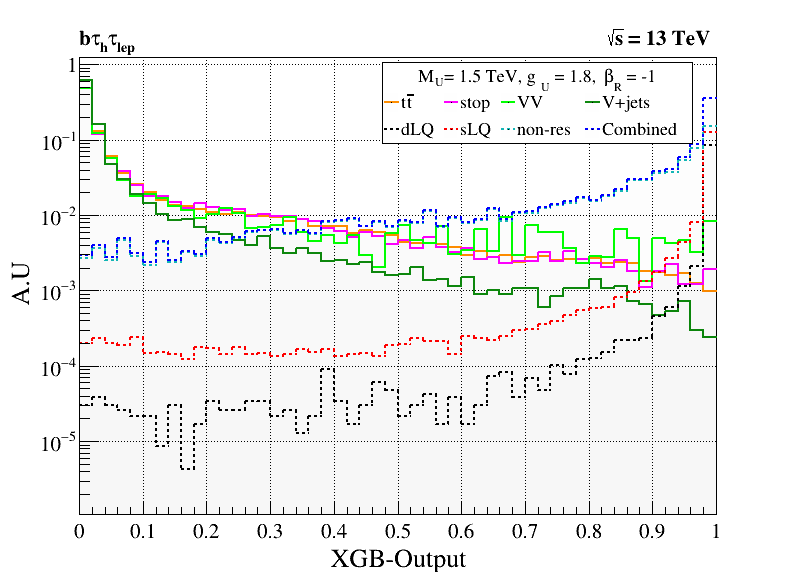

In [20]:
try: os.mkdir('Article_Histograms')
except: pass

M = '1500'

process = 'semileptonic_sLQ'
titulo = 'b#tau_{h}#tau_{lep}'

Histos, canvas, legend = Overlap_Histos(Histograms = all_histograms, 
                               betard = 'wRHC',
                               channel = process,
                               Mass = M, 
                               Title_Plot = titulo, 
                               Signal_to_ignore = '', 
                               alpha_bkg = 0.0, 
                               alpha_signal = 0.00, 
                               Log_Y = True, 
                               Log_X = False, 
                               Grid = False)

Histos.GetXaxis().CenterTitle(True)
Histos.GetYaxis().CenterTitle(True)

Histos.GetXaxis().SetTitleSize(0.05)
Histos.GetYaxis().SetTitleSize(0.05)
Histos.GetXaxis().SetLabelSize(0.04)
Histos.GetYaxis().SetLabelSize(0.04)

Histos.GetXaxis().SetLabelOffset(0.01)
Histos.GetYaxis().SetLabelOffset(0.0001)
Histos.GetXaxis().SetTitleOffset(1.0)
Histos.GetYaxis().SetTitleOffset(0.95)

Histos.GetXaxis().SetMaxDigits(2)
Histos.GetYaxis().SetMaxDigits(1)    
canvas.SetGrid()
canvas.SaveAs(os.path.join('Article_Histograms', f'ML_{process}_wRHC.pdf')) 

In [29]:
def Overlap_Histos(Histograms, 
                   betard,
                   channel,
                   Mass, 
                   Title_Plot, 
                   Signal_to_ignore = '', 
                   alpha_bkg = 0.05, 
                   alpha_signal = 0.05, 
                   Log_Y = False, 
                   Log_X = True, 
                   Grid = False):
    
    #if Stack is False -> Histograms will be normalized by A.U
    #if Stack is True -> Histograms will be normalized by number of physical events
    
    #canvas = TCanvas(Title_Plot, " ", 0, 0, 1280, 720)
    canvas = TCanvas(Title_Plot, " ", 0, 0, 800, 600)
    
    #legend = TLegend(0.9,.4,1,.89) #Legend outside the graph
    legend = TLegend(0.48,.75,0.87,.89)
    legend.SetTextFont(132)                   
    legend.SetNColumns(4) 
    legend.SetHeader('M_{U}' + f'= {int(Mass)/1000} TeV' + ', g_{U} = 1.8' + ', ' + header_by_betard[betard],"C")
    legend.SetLineWidth(1)
    #legend.SetFillStyle(0) #Transparent legend window
    
    x_axis = 'XGB-Output'
    
    Histos1 = THStack('hist1', Title_Plot)
    Histos2 = THStack('hist2', Title_Plot)
    Histos3 = THStack('hist3', Title_Plot)
                       
    Plotting_Order = ['t#bar{t}', 'stop', 'Diboson', 'V+jets', 'Lq Lq', '#tau Lq', '#tau #tau', 'Combined']
    
    Dict_Hist = Histograms[betard][channel][f'M{Mass}']
    holes = root_analysis.review_holes_in_histograms(Dict_Hist)
    
    colors = [94,51,99,209,4,2,432,1] #https://root-forum.cern.ch/t/what-is-your-best-way-to-increment-colors/13809
    for i, key in enumerate(Plotting_Order):
        
        if key in holes: histo = root_analysis.fill_holes_in_histogram(Dict_Hist[key])
        else: histo = Dict_Hist[key]
        
        color = colors[i]
        histo.SetLineColor(color)
        
        if key in ['t#bar{t}', 'stop', 'Diboson', 'V+jets']: alpha = alpha_bkg
        else: alpha = alpha_signal
        # histo.SetFillStyle(0)
        histo.SetFillColorAlpha(color, alpha)
        histo.SetDirectory(0)  
        histo.GetYaxis().SetRangeUser(0.00001,1)
        histo.GetXaxis().SetRangeUser(-1,1)
        histo.SetStats(0)
        if key in ['t#bar{t}', 'stop', 'Diboson', 'V+jets']: Histos1.Add(histo)
        if key in ['Lq Lq', '#tau Lq', '#tau #tau']: 

            histo.SetLineStyle(0)
            histo.SetLineWidth(0)
            
            if key == '#tau Lq':
                weight = 58.7/378.5
                histo.Scale(weight/histo.Integral())
            if key == 'Lq Lq':
                weight = 34.3/378.5
                histo.Scale(weight/histo.Integral())
            if key == '#tau #tau':
                weight = 285.5/378.5
                histo.Scale(weight/histo.Integral())
            
            Histos2.Add(histo)
            
        if key == 'Combined': 
            histo.SetLineStyle(2) 
            histo.SetLineWidth(2)
            histo.SetFillColorAlpha(color, 0.0)  
            # histo.SetMarkerStyle(21)            
            Histos3.Add(histo)
        
        label = key.replace('Lq Lq', 'dLQ').replace('#tau Lq', 'sLQ').replace('#tau #tau', 'non-res').replace('Diboson', 'VV')
        legend.AddEntry(histo,label)
            
    if Log_Y: canvas.SetLogy()
    if Log_X: canvas.SetLogx()
    if Grid: canvas.SetGrid()

        
    Histos3.Draw("histnostack")        
    Histos2.Draw("histsame")
    Histos1.Draw("histnostacksame")

    # Histos1.GetYaxis().SetRangeUser(0.00001,1)
    # Histos2.GetYaxis().SetRangeUser(0.00001,1)
    # Histos3.GetYaxis().SetRangeUser(0.00001,1)
                       
    Histos1.SetTitle(f'; {x_axis}; A.U')  
    Histos2.SetTitle(f'; {x_axis}; A.U')  
    Histos3.SetTitle(f'; {x_axis}; A.U')  
        
    latex = TLatex()
    latex.SetNDC()
    latex.SetTextSize(0.04)
    latex.SetTextFont(22) #https://root.cern.ch/doc/master/classTAttText.html
    latex.DrawLatex(0.76,0.92,'#sqrt{s} = 13 TeV')
    latex.DrawLatex(0.1,0.92,Title_Plot)

                       
    Histos1.GetXaxis().SetTitleFont(132)
    Histos1.GetXaxis().SetLabelFont(132)
    Histos1.GetYaxis().SetTitleFont(132)
    Histos1.GetYaxis().SetLabelFont(132)           
    Histos2.GetXaxis().SetTitleFont(132)
    Histos2.GetXaxis().SetLabelFont(132)
    Histos2.GetYaxis().SetTitleFont(132)
    Histos2.GetYaxis().SetLabelFont(132)   
    Histos3.GetXaxis().SetTitleFont(132)
    Histos3.GetXaxis().SetLabelFont(132)
    Histos3.GetYaxis().SetTitleFont(132)
    Histos3.GetYaxis().SetLabelFont(132)           

    canvas.Draw()
    legend.Draw('same')
    
    #Histos.GetXaxis().SetLimits(0.0, float(Mass)*3)          
                
    return Histos1, Histos2, Histos3, canvas, legend

Warning in <TCanvas::Constructor>: Deleting canvas with same name: b#tau_{h}#tau_{lep}
Info in <TCanvas::Print>: pdf file Article_Histograms/ML_semileptonic_sLQ_wRHC.pdf has been created


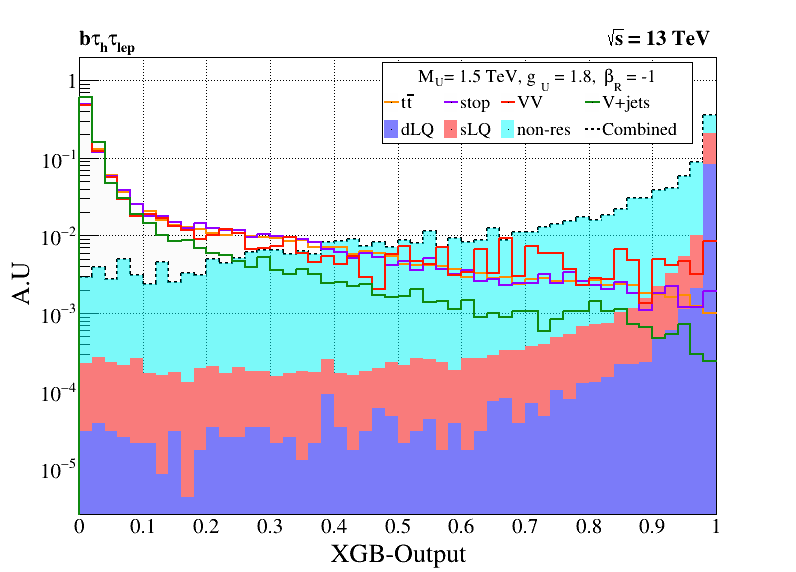

In [31]:
try: os.mkdir('Article_Histograms')
except: pass

M = '1500'

process = 'semileptonic_sLQ'
titulo = 'b#tau_{h}#tau_{lep}'

Histos1, Histos2, Histos3, canvas, legend = Overlap_Histos(Histograms = all_histograms, 
                               betard = 'wRHC',
                               channel = process,
                               Mass = M, 
                               Title_Plot = titulo, 
                               Signal_to_ignore = '', 
                               alpha_bkg = 0.0, 
                               alpha_signal = 0.5, 
                               Log_Y = True, 
                               Log_X = False, 
                               Grid = False)

Histos1.GetXaxis().CenterTitle(True)
Histos1.GetYaxis().CenterTitle(True)

Histos1.GetXaxis().SetTitleSize(0.05)
Histos1.GetYaxis().SetTitleSize(0.05)
Histos1.GetXaxis().SetLabelSize(0.04)
Histos1.GetYaxis().SetLabelSize(0.04)
Histos1.GetXaxis().SetTickLength(0.02)

Histos1.GetXaxis().SetLabelOffset(0.0001)
Histos1.GetYaxis().SetLabelOffset(0.0001)
Histos1.GetXaxis().SetTitleOffset(0.9)
Histos1.GetYaxis().SetTitleOffset(0.95)

Histos1.GetXaxis().SetMaxDigits(2)
Histos1.GetYaxis().SetMaxDigits(1)  

Histos2.GetXaxis().CenterTitle(True)
Histos2.GetYaxis().CenterTitle(True)

Histos2.GetXaxis().SetTitleSize(0.05)
Histos2.GetYaxis().SetTitleSize(0.05)
Histos2.GetXaxis().SetLabelSize(0.04)
Histos2.GetYaxis().SetLabelSize(0.04)

Histos2.GetXaxis().SetLabelOffset(0.0001)
Histos2.GetYaxis().SetLabelOffset(0.0001)
Histos2.GetXaxis().SetTitleOffset(0.9)
Histos2.GetYaxis().SetTitleOffset(0.95)

Histos2.GetXaxis().SetMaxDigits(2)
Histos2.GetYaxis().SetMaxDigits(1)  

Histos3.GetXaxis().CenterTitle(True)
Histos3.GetYaxis().CenterTitle(True)

Histos3.GetXaxis().SetTitleSize(0.05)
Histos3.GetYaxis().SetTitleSize(0.05)
Histos3.GetXaxis().SetLabelSize(0.04)
Histos3.GetYaxis().SetLabelSize(0.04)

Histos3.GetXaxis().SetLabelOffset(0.0001)
Histos3.GetYaxis().SetLabelOffset(0.0001)
Histos3.GetXaxis().SetTitleOffset(0.9)
Histos3.GetYaxis().SetTitleOffset(0.95)

Histos3.GetXaxis().SetMaxDigits(2)
Histos3.GetYaxis().SetMaxDigits(1)  
canvas.SetGrid()

canvas.SaveAs(os.path.join('Article_Histograms', f'ML_{process}_wRHC.pdf')) 